In [15]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import qcodes as qc
from qcodes.instrument_drivers.ZI.ZIUHFLI import ZIUHFLI

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

# Prerequisites

It is necessary to download and install the ZI Lab One software. Additionally, both the data server and the web server must run, and a connection to the instrument must be instantiated (this can be done via the web interface).

In [16]:
# Instantiate the QCoDeS instrument
zi = ZIUHFLI('ZIUHFLI', 'dev2189')

# Basic Usage of the ZI UHF-LI

Most of the "front panel" (i.e. the Web UI) `Lock-In` and `signal input` settings are available as parameters.

In [17]:
zi.oscillator1_freq.set(752.1e3)
print('Oscillator 2 has frequency: {:.0f} Hz'.format(zi.oscillator2_freq.get()))
zi.signal_input1_range(1)
zi.signal_input1_scaling(1)

Oscillator 2 has frequency: 1050 Hz


Each demodulator has several settings...

In [18]:
print('Available demodulator settings:\n')
for param in [p for p in zi.parameters if 'demod1' in p]:
    print('  {}, {} ({})'.format(param, zi.parameters[param].label, zi.parameters[param].unit))

Available demodulator settings:

  demod1_streaming, Data streaming ()
  demod1_order, Filter order ()
  demod1_timeconstant, Filter time constant (s)
  demod1_phaseshift, Phase shift (degrees)
  demod1_samplerate, Sample rate (Sa/s)
  demod1_sinc, Sinc filter ()
  demod1_signalin, Signal input ()
  demod1_trigger, Trigger ()
  demod1_harmonic, Reference frequency multiplication factor ()


# Using the sweeper

The sweeper settings are configured via a bunch of parameters, all named `sweeper_XXX`.
This configures the x-axis of the sweep as well as the sweep acquisition settings. To learn more about what a certain parameter does, it is sometimes helpful to print its `__doc__` attribute.

Which signals are **returned** by the sweeper is controlled by adding (removing) signals to (from) the sweep.

The sweep settings can be displayed with the `print_sweeper_settings` command.

Before the sweep can be performed, it must be built. 
This is done with the Sweep parameter, which is the parameter holding the sweep data.
Note that building the sweep may change some of the time constants, and in particular change the sweep time. In case of doubt, re-run `print_sweeper_settings`.

In [19]:
# Set up a sweep sweeping an internal oscillator frequency from 1 MHz to 5 MHz
# We want the sweeper to sweep linearly over 200 points
zi.sweeper_param('Osc 1 Frequency')
zi.sweeper_xmapping('lin')
zi.sweeper_start(1e6)
zi.sweeper_stop(5e6)
zi.sweeper_samplecount(200)
zi.sweeper_BWmode('fixed')
zi.sweeper_BW(250)
zi.sweeper_order(4)

In [20]:
# I wonder what the sweeper BWmode does...
print(zi.sweeper_BWmode.__doc__)


                                     For each sweep point, the demodulator
                                     filter bandwidth (time constant) may
                                     be either set automatically, be the
                                     current demodulator bandwidth or be
                                     a fixed number; the sweeper_BW
                                     parameter.
                                     

Parameter class:

* `name` sweeper_BWmode
* `label` Sweeper bandwidth control mode
* `unit` 
* `vals` <Enum: {'current', 'auto', 'fixed'}>


In [21]:
# Add three signals to the sweep, all measured on demodulator 1
zi.add_signal_to_sweeper(1, 'Xrms')
zi.add_signal_to_sweeper(1, 'Yrms')
zi.add_signal_to_sweeper(1, 'Rrms')

In [25]:
# Make sure that demodulator 1 is measuring what and as it should
zi.demod1_trigger('Continuous')
zi.demod1_signalin('Sig In 1')

In [26]:
# I wonder what kind of sweep we have made now...
zi.print_sweeper_settings()

ACQUISITION
    Sweeper bandwidth control mode: fixed ()
    Fixed bandwidth sweeper bandwidth (NEP): 50.0 ()
    Sweeper filter order: 1 ()
    Minimal no. of samples to average at each sweep point: 25 ()
    Minimal averaging time: 0.1 (s)
    Minimal settling time for the sweeper: 1e-06 (s)
    Sweep filter settling time: 4.605170185988091 (dim. less.)
HORISONTAL
    Start value of the sweep: 1000000.0
    Stop value of the sweep: 10000000.0
    Units of sweep x-axis: Hz
    Length of the sweep (pts): 25
    Parameter to sweep (sweep x-axis): Osc 1 Frequency
    Sweep mode: Sequential
    Sweep timeout: 20
VERTICAL
    Signal 1: Demodulator 1: Xrms
    Signal 2: Demodulator 1: Yrms
    Signal 3: Demodulator 1: Rrms
DEMODULATORS
    Demodulator 1: Filter time constant: 0.000266 (s)
    Demodulator 1: Filter order: 4.000000 ()
    Demodulator 1: Sample rate: 1716.613770 (Sa/s)
META
    Expected sweep time: 0.9 (s)
    Sweep timeout: 20 (s)
    Sweep built and ready to execute: False


In [27]:
# Gee, that looks good! Note the last line, the sweep is NOT ready to execute.
zi.Sweep.build_sweep()
# Now it is!
zi.print_sweeper_settings()

ACQUISITION
    Sweeper bandwidth control mode: fixed ()
    Fixed bandwidth sweeper bandwidth (NEP): 78.12499999999996 ()
    Sweeper filter order: 4 ()
    Minimal no. of samples to average at each sweep point: 25 ()
    Minimal averaging time: 0.1 (s)
    Minimal settling time for the sweeper: 1e-06 (s)
    Sweep filter settling time: 9.998049677807453 (dim. less.)
HORISONTAL
    Start value of the sweep: 1000000.0
    Stop value of the sweep: 5000000.0
    Units of sweep x-axis: Hz
    Length of the sweep (pts): 200
    Parameter to sweep (sweep x-axis): Osc 1 Frequency
    Sweep mode: Sequential
    Sweep timeout: 20
VERTICAL
    Signal 1: Demodulator 1: Xrms
    Signal 2: Demodulator 1: Yrms
    Signal 3: Demodulator 1: Rrms
DEMODULATORS
    Demodulator 1: Filter time constant: 0.000266 (s)
    Demodulator 1: Filter order: 4.000000 ()
    Demodulator 1: Sample rate: 1716.613770 (Sa/s)
META
    Expected sweep time: 4.9 (s)
    Sweep timeout: 20 (s)
    Sweep built and ready to exe

In [28]:
# We can now execute the sweeper by simply invoking Sweep.get
# This returns a tuple with the signals we asked for
(X, Y, R) = zi.Sweep.get()

In [ ]:
# This we may manually plot. 

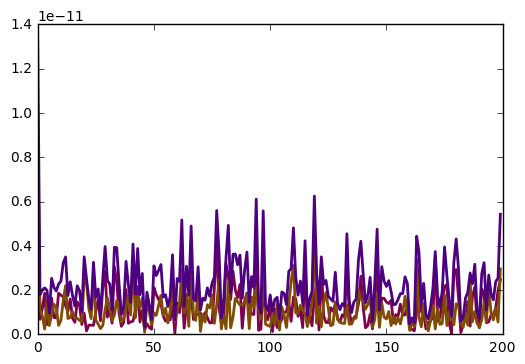

In [33]:
plt.figure()
plt.plot(X, lw=2, color=(0.5, 0, 0.3))
plt.plot(Y, lw=2, color=(0.5, 0.3, 0))
plt.plot(R, lw=2, color=(0.3, 0, 0.5))

In [36]:
zi.close()